In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns


from helpers import *
pandarallel.initialize()
from pandarallel import pandarallel  

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
# CONFIG
gtFine_path = './data/P8_Cityscapes_gtFine_trainvaltest.zip'  
leftImg8bit_path = './data/P8_Cityscapes_leftImg8bit_trainvaltest.zip'  
data_path = 'data/gtFine'  

config_width = 256 
config_height = 128
config_classes = 32
config_epoch = 3
batch_size=3


Using the full dataset
(2975, 5)
(1525, 5)
(500, 5)


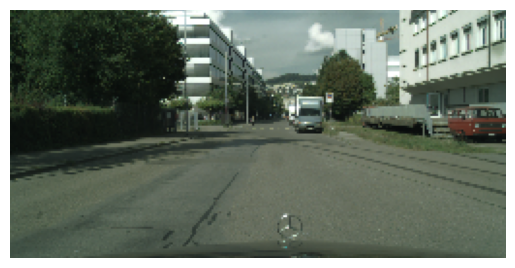

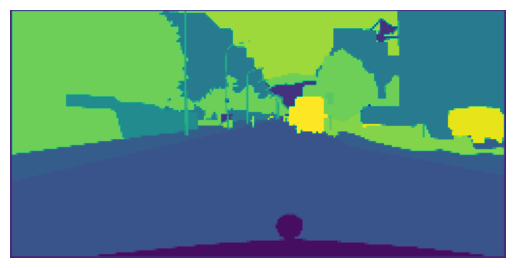

In [3]:
df_train, df_test, df_val = get_dataframes(data_path, sample_dataset=0)
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

def label_to_cat(label):  
    for cat, ids in categories.items():  
        if label in ids:  
            return cat  
    return None  
  
def read_image(x):  
    x = cv2.imread(x, cv2.IMREAD_COLOR)  
    x = cv2.resize(x, (config_width, config_height))  
    x = x/255.0  
    x = x.astype(np.float32)  
    return x  

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (config_width, config_height))  
    x = x.astype(np.int32)  
    return x  

img = read_image(df_train.loc[0]["original_img_path"])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
plt.axis('off')
plt.show()  

mask_now = read_mask(df_train.loc[0]["label_ids_img_path"])
plt.imshow(mask_now)  
plt.axis('off')
plt.show()  

In [4]:
# Configurable dimensions: Update these based on your requirement or config 
def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y)) # Dataset data object created from input and target data
    dataset = dataset.shuffle(buffer_size=100) ## selected from the first 100 samples
    dataset = dataset.map(preprocess) # Applying preprocessing to every batch in the Dataset object
    dataset = dataset.batch(batch) # Determine batch-size
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2) # Optimization to reduce waiting time on each object
    return dataset
        

def preprocess(x,y):
    def f(x,y):
        x = x.decode() ##byte stream conversion
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, config_classes, dtype=tf.int32)
    
    image.set_shape([config_height, config_width, 3])    
    mask.set_shape([config_height, config_width, config_classes])
    
    return image, mask

img_train = df_train["original_img_path"].tolist()
mask_train = df_train["label_ids_img_path"].tolist()

img_val = df_val["original_img_path"].tolist()
mask_val = df_val["label_ids_img_path"].tolist()

img_test = df_test["original_img_path"].tolist()
mask_test = df_test["label_ids_img_path"].tolist()

train_dataset = tf_dataset(img_train, mask_train, batch = batch_size)
valid_dataset = tf_dataset(img_val, mask_val, batch = batch_size)

train_steps = len(img_train)//batch_size
valid_steps = len(img_val)//batch_size

def test_dataset(x, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.map(preprocess_test)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset
        

def preprocess_test(x):
    def f(x):
        x = x.decode()
        image = read_image(x)
        return image
    
    image = tf.convert_to_tensor(tf.numpy_function(f, [x] , [tf.float32]))
    image = tf.reshape(image, (config_height, config_width, 3))  
    return image

def multi_unet_model(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model.summary()
    
    return model

model = multi_unet_model(n_classes=config_classes, IMG_HEIGHT=config_height, IMG_WIDTH=config_width, IMG_CHANNELS=3)
model

2024-02-25 21:22:45.945444: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-25 21:22:45.945464: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-25 21:22:45.945469: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-25 21:22:45.945498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-25 21:22:45.945514: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [5]:
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)
history = model.fit(train_dataset,
          steps_per_epoch=train_steps,
          validation_data=valid_dataset,
          validation_steps=valid_steps,
          epochs=config_epoch
         )

Epoch 1/3


2024-02-25 21:22:46.973413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


991/991 [==============================] - 166s 167ms/step - loss: 1.2163 - accuracy: 0.6546 - val_loss: 1.1949 - val_accuracy: 0.7134
Epoch 2/3
991/991 [==============================] - 165s 166ms/step - loss: 0.8309 - accuracy: 0.7733 - val_loss: 1.0921 - val_accuracy: 0.7340
Epoch 3/3
991/991 [==============================] - 165s 166ms/step - loss: 0.8908 - accuracy: 0.7700 - val_loss: 1.5708 - val_accuracy: 0.6497


In [6]:
df_test.loc[0]["label_ids_img_path"]

'data/gtFine/test/bielefeld/bielefeld_000000_005741_gtFine_labelIds.png'

10/10 [==============================] - 0s 29ms/step


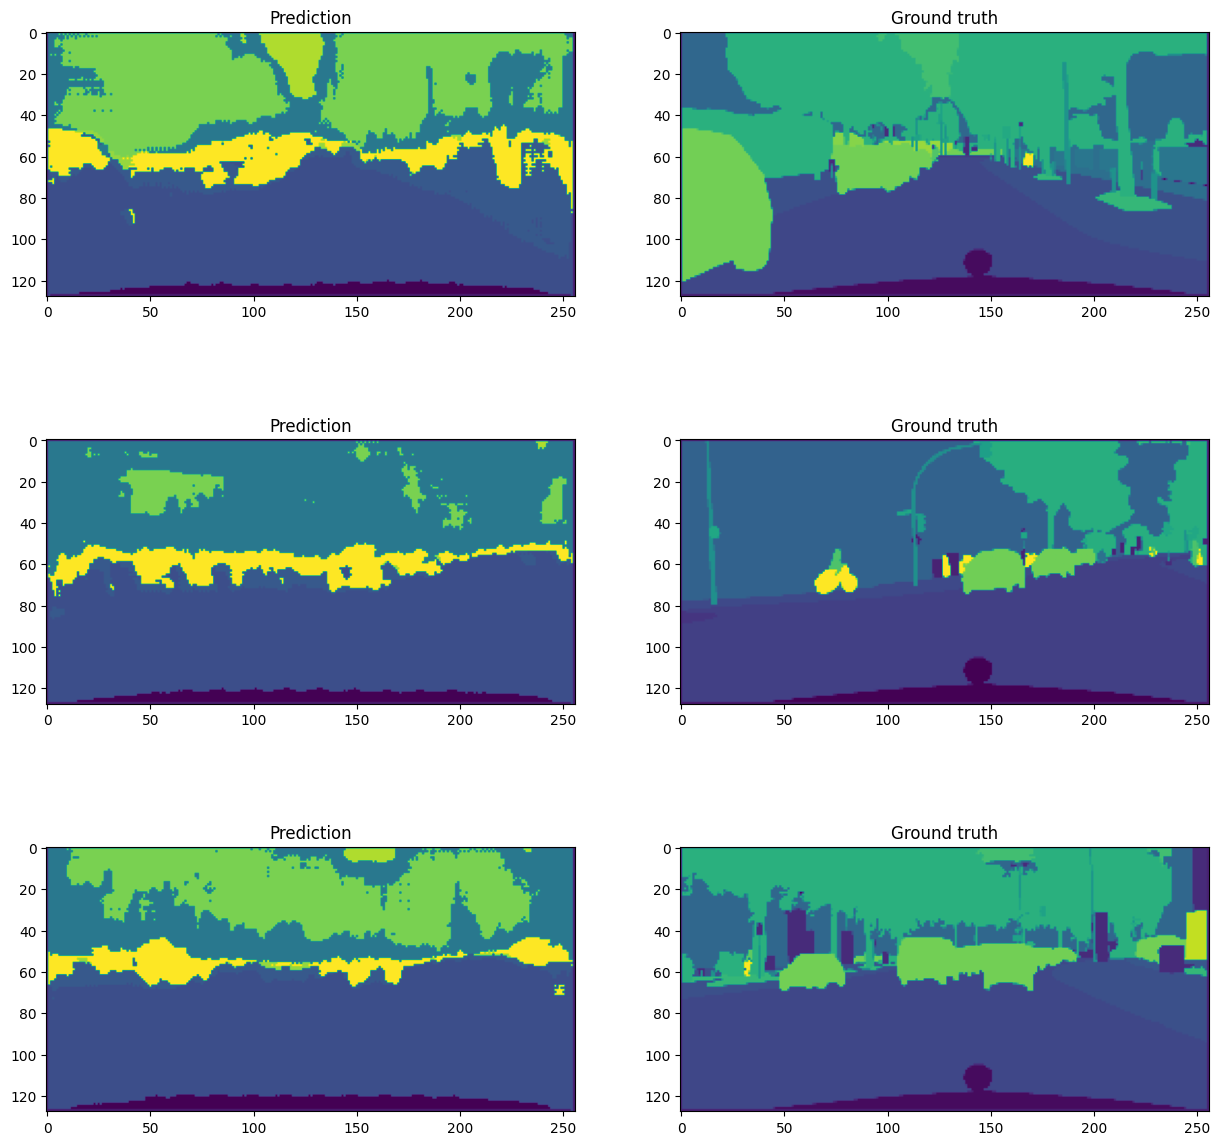

In [7]:
test_ds = tf_dataset(img_val, mask_val, batch = batch_size)
# test_ds = tf_dataset(img_test, mask_test, batch = batch_size)
model.evaluate(test_ds, steps=14)
pred = model.predict(test_dataset(img_val, batch = 1), steps=10)
# pred = model.predict(test_dataset(img_test, batch = 1), steps=10)

predictions = np.argmax(pred, axis=3)
label = np.array([cv2.resize(cv2.imread(df_val.loc[i]["label_ids_img_path"])[:, :, 0], (config_width, config_height)) for i in range(predictions.shape[0])])  
# label = np.array([cv2.resize(cv2.imread(df_test.loc[i]["label_ids_img_path"])[:, :, 0], (config_width, config_height)) for i in range(predictions.shape[0])])  
label = label.flatten()
predictions = predictions.flatten()

predictions = predictions.reshape(-1, config_height, config_width)  
label = label.reshape(-1, config_height, config_width)  

i = 3

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for j in range(3):
    ax[j, 0].imshow(predictions[i+j], cmap="viridis")
    ax[j, 1].imshow(label[i+j], cmap="viridis")
    ax[j, 0].set_title('Prediction')
    ax[j, 1].set_title('Ground truth')
    ax[j, 0].grid(False)
    ax[j, 1].grid(False)
    
plt.show()

In [11]:
model.save("model_v4_full.h5")

1/1 [==============================] - 0s 14ms/step


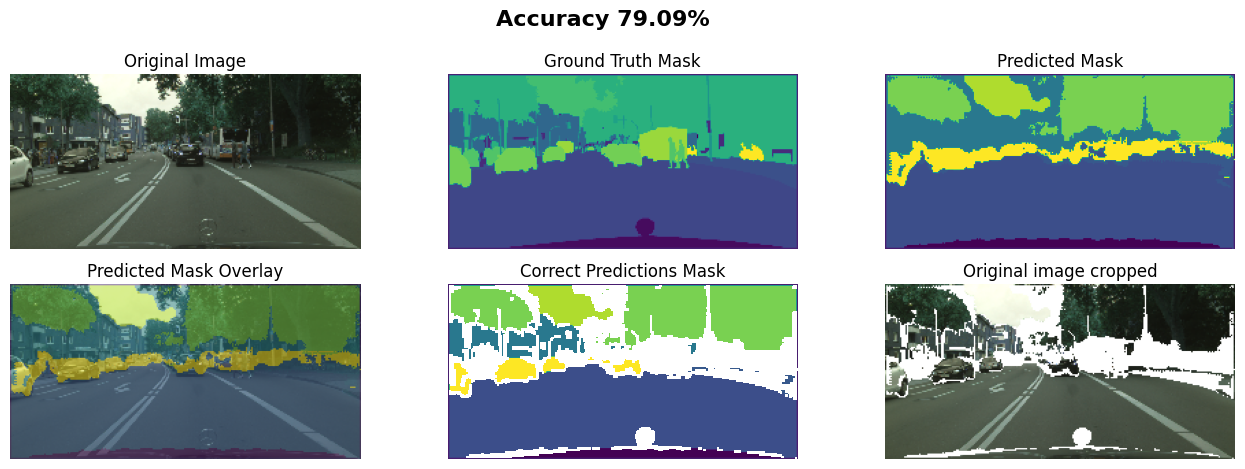

Accuracy: 79.09%


In [17]:
import matplotlib as mpl  

def read_overlay_pred(image, mask, mask_opacity=0.5):
    color_map = mpl.colormaps.get_cmap('viridis')  

    mask_img_array_normalized = mask / mask.max()  
    mask_img_colored = color_map(mask_img_array_normalized)[:, :, :3]  # Exclude the alpha channel  
    mask_img_colored = (mask_img_colored * 255).astype(np.uint8)  
      
    overlayed = cv2.addWeighted(src1=image, alpha=(1-mask_opacity), src2=mask_img_colored.astype(np.float32)/255.0, beta=mask_opacity, gamma=0)  
    
    return overlayed


def predict_and_display_image_with_accuracy(image_path, truth_mask_path, model):  
    # Load and preprocess the image  
    image = read_image(image_path)
    image_to_predict = np.expand_dims(image, axis=0)  # Add batch dimension  
      
    # Load and preprocess the truth mask  
    truth_mask = read_mask(truth_mask_path)  # Using the read_mask function defined earlier  
    truth_mask_resized = cv2.resize(truth_mask, (model.input_shape[2], model.input_shape[1]), interpolation=cv2.INTER_NEAREST)  # Resizing to match the model's input  
  
    # Predict the mask using the model  
    prediction = model.predict(image_to_predict)  
    predicted_mask = tf.argmax(prediction, axis=-1)[0]  # Remove batch dimension and convert prediction to class labels  
  
    # Calculate accuracy  
    accuracy = np.mean(predicted_mask == truth_mask_resized)  # Assumes truth_mask is already an int32 numpy array of labels  
    
    overlay_img = read_overlay_pred(image, predicted_mask.numpy())
    
    correct_predictions_mask = np.where(predicted_mask == truth_mask_resized, predicted_mask, np.nan)  # Use np.nan for non-correct pixels    
    # correct_predictions_mask_test = np.where(predicted_mask == truth_mask_resized, predicted_mask, np.nan)  # Use np.nan for non-correct pixels    
    
    correct_predictions_image = np.where(np.expand_dims(predicted_mask.numpy() == truth_mask_resized, axis=-1), image, 1) # This replaces incorrect predictions with black  

    # Display images
    titles_and_images = [  
        ('Original Image', image),  
        ('Ground Truth Mask', truth_mask_resized),  
        ('Predicted Mask', predicted_mask),  
        ('Predicted Mask Overlay', overlay_img),
        ('Correct Predictions Mask', correct_predictions_mask),
        ('Original image cropped', correct_predictions_image),
    ]  
    
    # Setting up the figure for 2 rows and 2 columns  
    plt.figure(figsize=(16, 5))  
    plt.suptitle(f'Accuracy {accuracy*100:.2f}%', fontsize=16, fontweight='bold', y=1.01)  
    
    for i, (title, img) in enumerate(titles_and_images, start=1):
        plt.subplot(2, 3, i)  
        plt.title(title)
        plt.imshow(img)
            
        plt.axis('off') 
         
    plt.show()  
  
    print(f"Accuracy: {accuracy*100:.2f}%")  


predict_and_display_image_with_accuracy(img_val[0],mask_val[0], model)